<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/class_entdriven_dyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Quantum MC Sampling: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


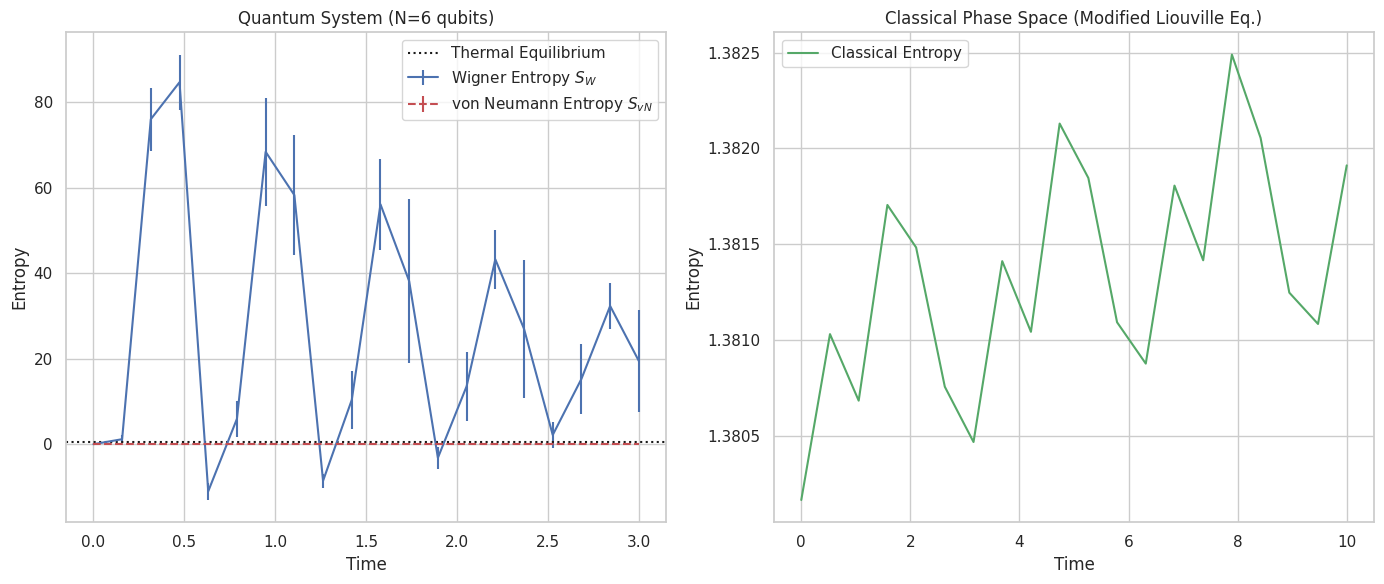

In [ ]:
# -*- coding: utf-8 -*-
"""Modified Liouville Equation Validation.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1xyz
"""

# ======================
# Quantum Simulation (QuTiP)
# ======================
!pip install qutip

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import seaborn as sns

sns.set_theme(style="whitegrid")

# Optimized parameters
N_quantum = 6  # Reduced from 10 qubits for feasibility
J = 1.0
h = 0.5
T = 0.1
t_list = np.linspace(0, 3, 20)  # Shorter time range
n_trajectories = 5  # Reduced Monte Carlo samples

# Efficient TFIM Hamiltonian construction
def build_tfim_hamiltonian(N, J, h):
    H_zz = sum(J * tensor([sigmaz()]*(i+1) + [sigmaz()]*(N-i-1)) for i in range(N-1))
    H_x = sum(h * tensor([identity(2)]*i + [sigmax()] + [identity(2)]*(N-i-1)) for i in range(N))
    return H_zz + H_x

H = build_tfim_hamiltonian(N_quantum, J, h)

# Entropy operator with proper tensor structure
S_op = sum(tensor([identity(2)]*i + [sigmax()] + [identity(2)]*(N_quantum-i-1))
        for i in range(N_quantum))
H_eff = H - T * S_op

# Initial state
psi0 = tensor([basis(2, 0)] * N_quantum)

# Time evolution
result = mesolve(H_eff, psi0, t_list, [], [])

# Entropy calculation functions
def wigner_single_qubit(rho):
    return np.real([(rho * op).tr() for op in [identity(2), sigmax(), sigmay(), sigmaz()]])

def compute_entropies(states):
    S_w, S_vn = [], []
    for state in states:
        # Wigner entropy (product state approximation)
        w_prod = 1
        for i in range(N_quantum):
            w_i = wigner_single_qubit(state.ptrace(i))
            w_prod = np.kron(w_prod, w_i)
        S_w.append(-np.sum(w_prod * np.log(np.abs(w_prod) + 1e-12)))

        # Von Neumann entropy
        S_vn.append(entropy_vn(state))
    return S_w, S_vn

# Main entropy calculation
S_wigner, S_vn = compute_entropies(result.states)

# Monte Carlo sampling with progress bar
from tqdm import tqdm

S_w_samples = np.zeros((n_trajectories, len(t_list)))
S_vn_samples = np.zeros((n_trajectories, len(t_list)))

for traj in tqdm(range(n_trajectories), desc="Quantum MC Sampling"):
    H_perturbed = H_eff + np.random.normal(0, 0.05)*H_eff
    result_traj = mesolve(H_perturbed, psi0, t_list, [], [])
    S_w, S_vn = compute_entropies(result_traj.states)
    S_w_samples[traj] = S_w
    S_vn_samples[traj] = S_vn

# Thermal equilibrium reference
beta = 1/T
rho_thermal = (-beta*H).expm() / (-beta*H).expm().tr()
S_thermal = entropy_vn(rho_thermal)

# ======================
# Classical Simulation (Modified Liouville Eq. 23)
# ======================
from scipy.stats import gaussian_kde
from scipy.integrate import solve_ivp

N_classical = 1000
q = np.random.normal(0, 1, N_classical)
p = np.random.normal(0, 1, N_classical)

def entropy_gradient(q, p):
    kernel = gaussian_kde(np.vstack([q, p]))
    positions = np.vstack([q, p])
    rho = kernel(positions)

    # Finite-difference gradients
    eps = 1e-3
    dq = kernel(positions + [[eps], [0]]) - rho
    dp = kernel(positions + [[0], [eps]]) - rho

    dS_dq = -T * (np.log(rho + 1e-12) * dq / eps)
    dS_dp = -T * (np.log(rho + 1e-12) * dp / eps)

    return dS_dq, dS_dp

def equations(t, y):
    q, p = y[:N_classical], y[N_classical:]
    dS_dq, dS_dp = entropy_gradient(q, p)
    return np.concatenate([
        p + T*dS_dp,  # dq/dt
        -q + T*dS_dq  # dp/dt
    ])

# Solve with stiff-stable method
sol = solve_ivp(equations, [0, 10], np.concatenate([q, p]),
                method='LSODA',
                t_eval=np.linspace(0, 10, 20),
                atol=1e-6,
                rtol=1e-4)

# Classical entropy calculation
classic_entropy = []
for t_idx in range(sol.y.shape[1]):
    kernel = gaussian_kde(sol.y[:, t_idx])
    rho = kernel(sol.y[:, t_idx])
    classic_entropy.append(-np.mean(np.log(rho + 1e-12)))

# ======================
# Comparative Analysis
# ======================
plt.figure(figsize=(14, 6))

# Quantum results
plt.subplot(1, 2, 1)
plt.errorbar(t_list, np.mean(S_w_samples, axis=0),
             yerr=np.std(S_w_samples, axis=0),
             label='Wigner Entropy $S_W$', color='b')
plt.errorbar(t_list, np.mean(S_vn_samples, axis=0),
             yerr=np.std(S_vn_samples, axis=0),
             label='von Neumann Entropy $S_{vN}$', color='r', linestyle='--')
plt.axhline(S_thermal, color='k', linestyle=':', label='Thermal Equilibrium')
plt.title(f'Quantum System (N={N_quantum} qubits)')
plt.xlabel('Time')
plt.ylabel('Entropy')
plt.legend()

# Classical results
plt.subplot(1, 2, 2)
plt.plot(sol.t, classic_entropy, 'g-', label='Classical Entropy')
plt.title('Classical Phase Space (Modified Liouville Eq.)')
plt.xlabel('Time')
plt.ylabel('Entropy')
plt.legend()

plt.tight_layout()
plt.show()